In [16]:
import apoc
import napari
import numpy as np
from pathlib import Path
import os
from utils import list_images, read_image
import matplotlib.pyplot as plt
import tifffile
from utils import count_points_in_labels, filter_points_interpolated

In [2]:
# Define input folders
image_folder = Path("./raw_data/SD_RFP_spot_detection_training/images")
annotation_folder = Path("./raw_data/SD_RFP_spot_detection_training/annotations")

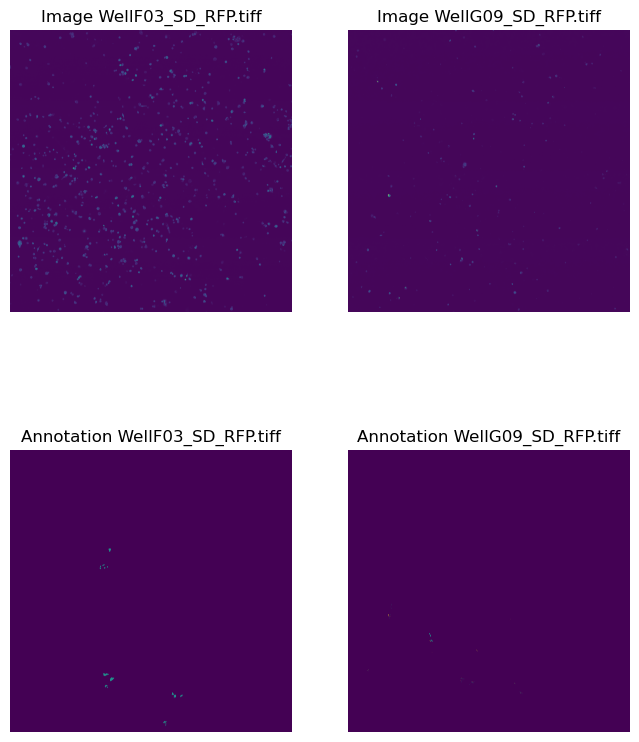

In [3]:
# Get the list of file names in the images and masks folder
image_file_list = [file_path.name for file_path in image_folder.glob("*.tiff")]
masks_file_list = [file_path.name for file_path in annotation_folder.glob("*.tiff")]

# Ensure the masks folder has the same number of files as the images folder
assert len(image_file_list) == len(masks_file_list), "Number of images and masks must be the same."

# Show images and corresponding masks side by side
num_images = len(image_file_list)
fig, axs = plt.subplots(2, num_images, figsize=(4 * num_images, 10))

for i, (image_filename, mask_filename) in enumerate(zip(image_file_list, masks_file_list)):
    # Plot the image
    image = tifffile.imread(os.path.join(image_folder, image_filename))
    axs[0, i].imshow(image)
    axs[0, i].axis("off")
    axs[0, i].set_title(f"Image {image_filename}")

    # Plot the corresponding mask
    mask = tifffile.imread(os.path.join(annotation_folder, mask_filename))
    axs[1, i].imshow(mask, cmap="viridis")  # Use cmap='viridis' for multinary masks
    axs[1, i].axis("off")
    axs[1, i].set_title(f"Annotation {mask_filename}")
    
plt.show()

In [4]:
# Setup classifer and where it should be saved
cl_filename = "./raw_data/SD_RFP_spot_detection_training/Gal3_segmenter.cl"
apoc.erase_classifier(cl_filename)
segmenter = apoc.PixelClassifier(opencl_filename=cl_filename)

# Setup feature set used for training
features = apoc.PredefinedFeatureSet.object_size_1_to_5_px.value #TODO: Check

# Train classifier on folders
apoc.train_classifier_from_image_folders(
    segmenter, 
    features, 
    image = image_folder, 
    ground_truth = annotation_folder)

In [5]:
# Load the trained segmenter
viewer = napari.Viewer(ndisplay=2)
segmenter = apoc.PixelClassifier(opencl_filename=cl_filename)

In [6]:
# Copy the path where your images are stored, you can use absolute or relative paths to point at other disk locations
directory_path = Path("X:\Lisa\siMtb screen I_LØ\Plate 01_Nuc")

# Iterate through the .czi and .nd2 files in the directory
images = list_images(directory_path)

# Image size reduction (downsampling) to improve processing times (slicing, not lossless compression)
slicing_factor_xy = None # Use 2 or 4 for downsampling in xy (None for lossless)

images

['X:\\Lisa\\siMtb screen I_LØ\\Plate 01_Nuc\\Plate01_Nuc_Wells-A1__Channel_SD_AF647,SD_RFP,SD_GFP,SD_DAPI,SD_BF,SD_NIR.nd2',
 'X:\\Lisa\\siMtb screen I_LØ\\Plate 01_Nuc\\Plate01_Nuc_Wells-A2__Channel_SD_AF647,SD_RFP,SD_GFP,SD_DAPI,SD_BF,SD_NIR.nd2',
 'X:\\Lisa\\siMtb screen I_LØ\\Plate 01_Nuc\\Plate01_Nuc_Wells-A3__Channel_SD_AF647,SD_RFP,SD_GFP,SD_DAPI,SD_BF,SD_NIR.nd2',
 'X:\\Lisa\\siMtb screen I_LØ\\Plate 01_Nuc\\Plate01_Nuc_Wells-A4__Channel_SD_AF647,SD_RFP,SD_GFP,SD_DAPI,SD_BF,SD_NIR.nd2',
 'X:\\Lisa\\siMtb screen I_LØ\\Plate 01_Nuc\\Plate01_Nuc_Wells-A5__Channel_SD_AF647,SD_RFP,SD_GFP,SD_DAPI,SD_BF,SD_NIR.nd2',
 'X:\\Lisa\\siMtb screen I_LØ\\Plate 01_Nuc\\Plate01_Nuc_Wells-A6__Channel_SD_AF647,SD_RFP,SD_GFP,SD_DAPI,SD_BF,SD_NIR.nd2',
 'X:\\Lisa\\siMtb screen I_LØ\\Plate 01_Nuc\\Plate01_Nuc_Wells-A7__Channel_SD_AF647,SD_RFP,SD_GFP,SD_DAPI,SD_BF,SD_NIR.nd2',
 'X:\\Lisa\\siMtb screen I_LØ\\Plate 01_Nuc\\Plate01_Nuc_Wells-A8__Channel_SD_AF647,SD_RFP,SD_GFP,SD_DAPI,SD_BF,SD_NIR.nd2',


In [ ]:
# Test classifier in a few images 
image = images[1]

# Read image, apply slicing if needed and return filename and img as a np array
img, filename = read_image(image, slicing_factor_xy)

predicted_labels = segmenter.predict(img[1])
viewer.add_image(img[1])



Image analyzed: Plate01_Nuc_Wells-A2__Channel_SD_AF647,SD_RFP,SD_GFP,SD_DAPI,SD_BF,SD_NIR
Original Array shape: (6, 5032, 5032)
Compressed Array shape: (6, 5032, 5032)


<Labels layer 'predicted_labels' at 0x2181b4b4370>

## Down below is just trying the filtering logic for points according to the mask predicted by the classifier

In [8]:
from spotiflow.model import Spotiflow

#Load pre-trained Cellpose-SAM and Spotiflow models
spotiflow_model = Spotiflow.from_pretrained("general")

c:\Users\adiez_cmic\miniforge3\envs\hcs_cellpose\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO:spotiflow.model.spotiflow:Loading pretrained model: general


In [ ]:
points, details = spotiflow_model.predict(img[1], subpix=True)
viewer.add_points(points, face_color='red')

INFO:spotiflow.model.spotiflow:Will use device: cuda:0
INFO:spotiflow.model.spotiflow:Predicting with prob_thresh = [0.6], min_distance = 1
INFO:spotiflow.model.spotiflow:Peak detection mode: fast
INFO:spotiflow.model.spotiflow:Image shape (5032, 5032)
INFO:spotiflow.model.spotiflow:Predicting with (3, 3) tiles
INFO:spotiflow.model.spotiflow:Normalizing...
INFO:spotiflow.model.spotiflow:Padding to shape (5040, 5040, 1)


Predicting tiles: 100%|██████████| 9/9 [00:02<00:00,  3.09it/s]

INFO:spotiflow.model.spotiflow:Found 1224 spots


<Points layer 'points' at 0x2182fd436a0>

In [10]:
filtered_points = filter_points_interpolated(points, predicted_labels)

In [11]:
viewer.add_points(filtered_points, face_color='blue')

<Points layer 'filtered_points' at 0x218446fe500>

In [13]:
viewer.add_labels(predicted_labels)

<Labels layer 'predicted_labels [1]' at 0x2184716e4d0>

## Now trying to count how many points lie within each cell label

In [14]:
from cellpose import models, core, io

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

#Load pre-trained Cellpose-SAM and Spotiflow models
model = models.CellposeModel(gpu=True)



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.6 
platform:       	win32 
python version: 	3.10.18 
torch version:  	2.5.0! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 


2025-09-29 12:56:24,635 [INFO] WRITING LOG OUTPUT TO C:\Users\adiez_cmic\.cellpose\run.log
2025-09-29 12:56:24,635 [INFO] 
cellpose version: 	4.0.6 
platform:       	win32 
python version: 	3.10.18 
torch version:  	2.5.0
2025-09-29 12:56:24,635 [INFO] ** TORCH CUDA version installed and working. **
2025-09-29 12:56:24,635 [INFO] ** TORCH CUDA version installed and working. **
2025-09-29 12:56:24,635 [INFO] >>>> using GPU (CUDA)
2025-09-29 12:56:25,513 [INFO] >>>> loading model C:\Users\adiez_cmic\.cellpose\models\cpsam


In [17]:
cytoplasm_labels, flows, styles = model.eval(np.stack((img[[0,1]].sum(axis=0), (img[4])), axis=0), niter=1000)

In [18]:
viewer.add_labels(cytoplasm_labels)

<Labels layer 'cytoplasm_labels' at 0x218a9ca4e50>

In [19]:
counts_df = count_points_in_labels(filtered_points, cytoplasm_labels)

In [20]:
counts_df
counts_df.to_csv("counts.csv", index=False)
